# DEMETER Satellite - IAP Sensor Data Processing

## Calculating correction terms for $\mathrm{H}^{+}$ ion data

### Initialization

Loading in necessary libraries:

In [12]:
rd = reload(rd)

In [228]:
import fun.read_data as rd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from importlib import reload
from os import listdir
from scipy.optimize import leastsq
from scipy.fftpack import fft, ifft, rfft

%matplotlib inline

In [ ]:
def calc_dist(x, y, a, b):

    """
    Calculates the distance of points x,y from the line defined by
    the equation: y = ax + b
    """

    from math import sqrt

    return np.abs(a * x - y + b) / sqrt(a * a + 1)

Loading data files.

In [39]:
data_dir = '/home/istvan/work/demeter/IAP_data/'
input_paths = [data_dir + path for path in listdir(data_dir)]

In [40]:
# required field: CNES Julian day, H+ ion densities, magnetic latitude and longitude
req = ['cnesjd', 'h', 'mlat', 'mlon', 'alt']

# Loading only day data
day, _ = rd.read_data(input_paths, required=req)

In [46]:
# filtering out low ion densities and restricitng mag. lat. values
day = day[(day['h']  < 1.4e4) & (day['h'] > 100) & (day['mlat'] > -60) & (day['mlat'] < 60)]

Binning data for mag.lat. values and CNES Julian day values.

In [186]:
h_binnum = 1e3
mlat_binnum = 120
cnesjd_binnum = 250;

In [119]:
# creating bins, from max. to min. 1 degree bin width
mlat_mean, mlat_bins, _ = stats.binned_statistic(day['mlat'], day['h'], statistic='mean', bins=mlat_binnum)
mlat_half_bin = (mlat_bins[1] - mlat_bins[0]) / 2.0

In [243]:
# creating bins, from max. to min. 20 day bin width
cnesjd_mean, cnesjd_bins, _ = stats.binned_statistic(day['cnesjd'], day['h'],
                                                       statistic='mean', bins=cnesjd_binnum)
cnesjd_half_bin = (cnesjd_bins[1] - cnesjd_bins[0]) / 2.0

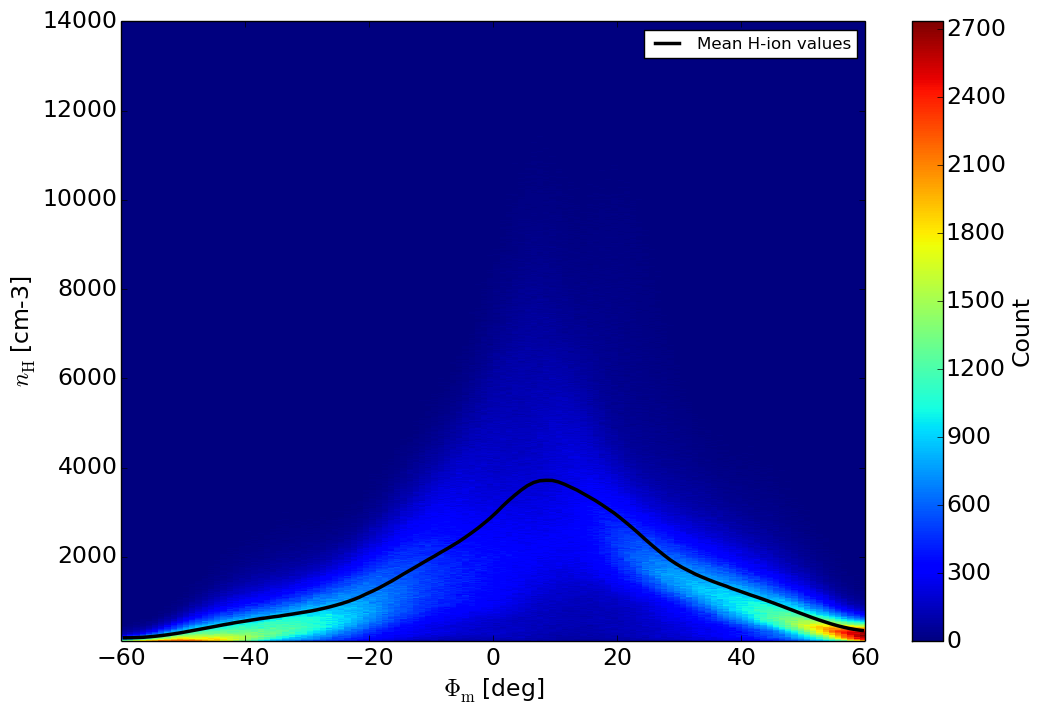

In [172]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['mlat'], day['h'], bins=[mlat_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

plt.plot(mlat_bins[0:-1] + mlat_half_bin, mlat_median, 'k-', linewidth=2.5, label='Mean H-ion values')
plt.legend();

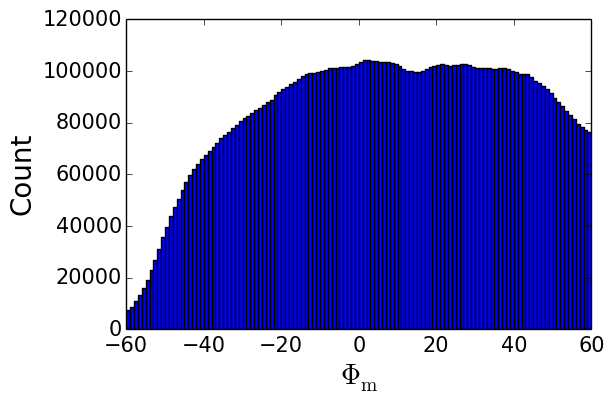

In [86]:
plt.figure(dpi=100)
n, _, _ = plt.hist(day['mlat'], bins=mlat_binnum);
plt.xlabel(r'$\Phi_{\mathrm{m}}$', size=20)
plt.ylabel('Count', size=20)
plt.tick_params(labelsize=15)

In [9]:
counts = np.rot90(counts)

In [88]:
counts_corrected = np.multiply(counts, np.tile(np.reciprocal(n), (h_binnum, 1)))

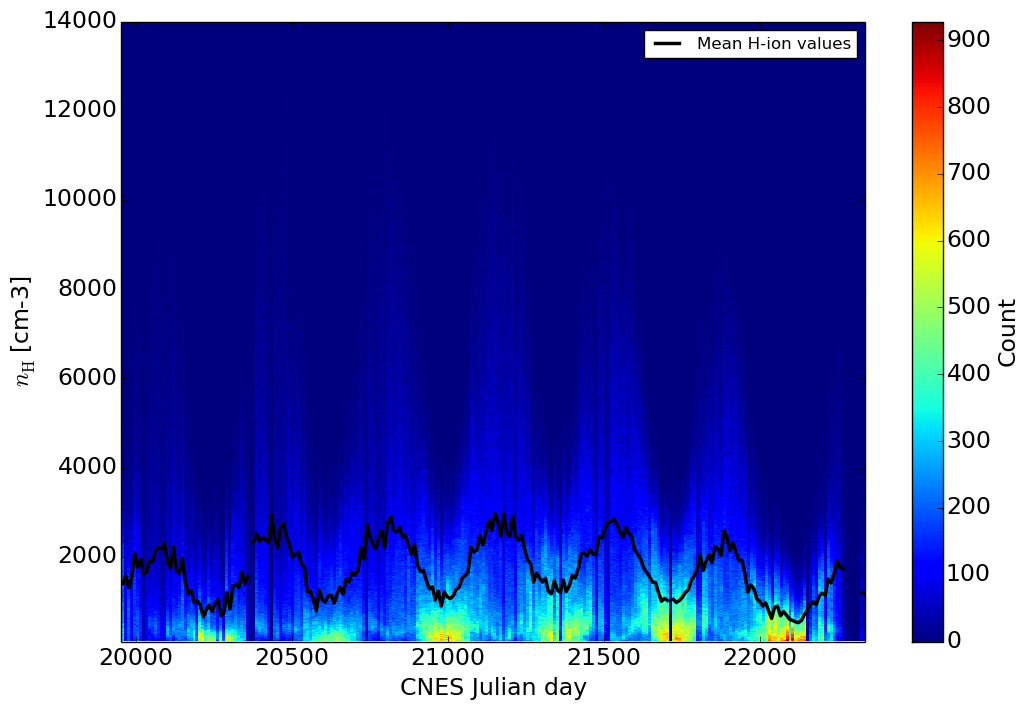

In [244]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel('CNES Julian day', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['cnesjd'], day['h'], bins=[cnesjd_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

plt.plot(cnesjd_bins[:-1] + cnesjd_half_bin, cnesjd_mean, 'k-', linewidth=2.5, label='Mean H-ion values')
plt.legend();

In [280]:
z, V = np.polyfit(mlat_bins[0:-1] + mlat_half_bin, np.log10(mlat_mean), 5, cov=True)
p = np.poly1d(z)
mlat = np.arange(mlat_bins.min(), mlat_bins.max(), 1)

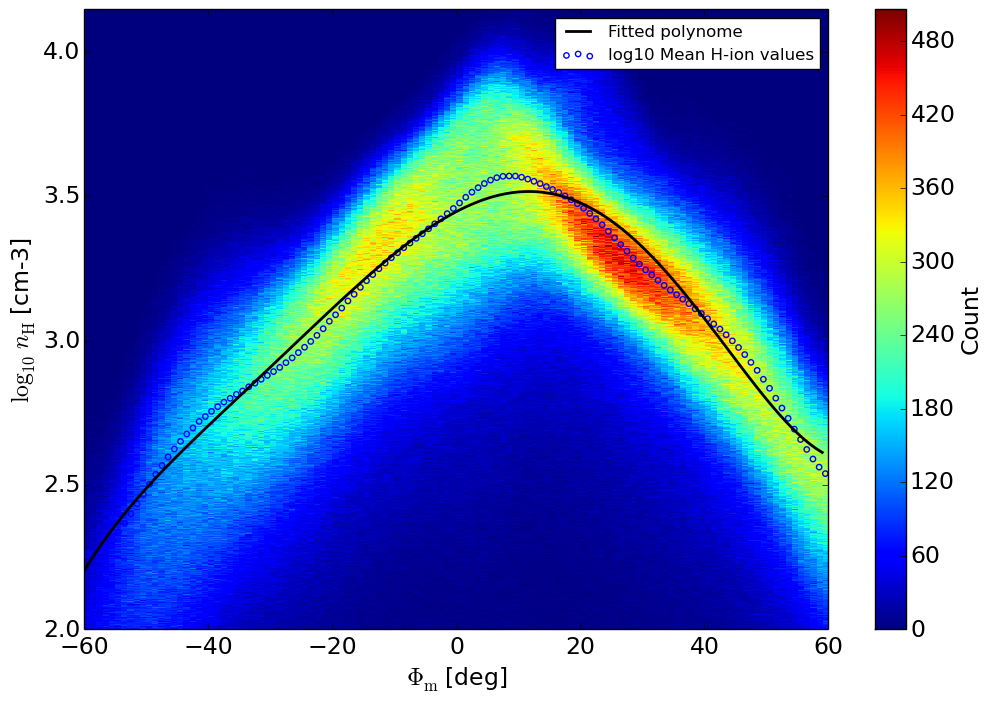

In [173]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$\mathrm{log}_{10}$ $n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['mlat'], np.log10(day['h']), bins=[mlat_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

points = plt.scatter(mlat_bins[0:-1] + mlat_half_bin, np.log10(mlat_mean), s=15, edgecolor='b',
                     facecolor='none', label=r'log10 Mean H-ion values');
line = plt.plot(mlat, p(mlat), 'k-', label='Fitted polynome', linewidth=2)
plt.legend();

In [281]:
h_corr = np.power(10, p(day['mlat']))

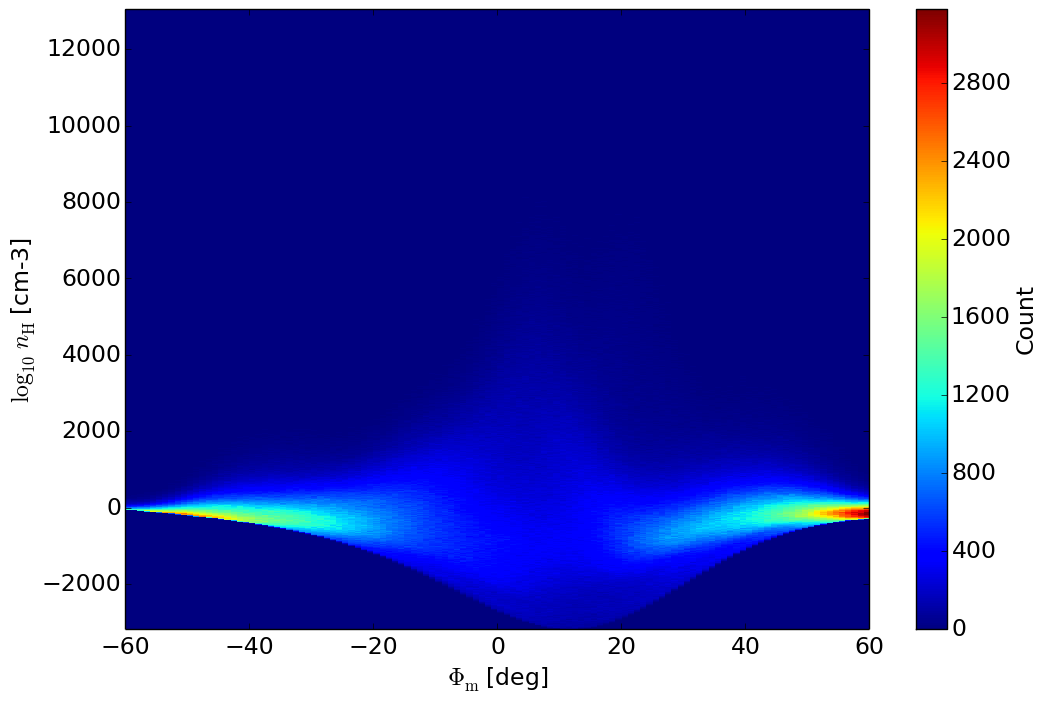

In [175]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['mlat'], day['h'] - h_corr, bins=[mlat_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

In [282]:
cnesjd_mean, _, _ = stats.binned_statistic(day['cnesjd'], day['h'] - h_corr,
                                                       statistic='mean', bins=cnesjd_bins)

In [283]:
not_nan = np.logical_not(np.isnan(cnesjd_mean))

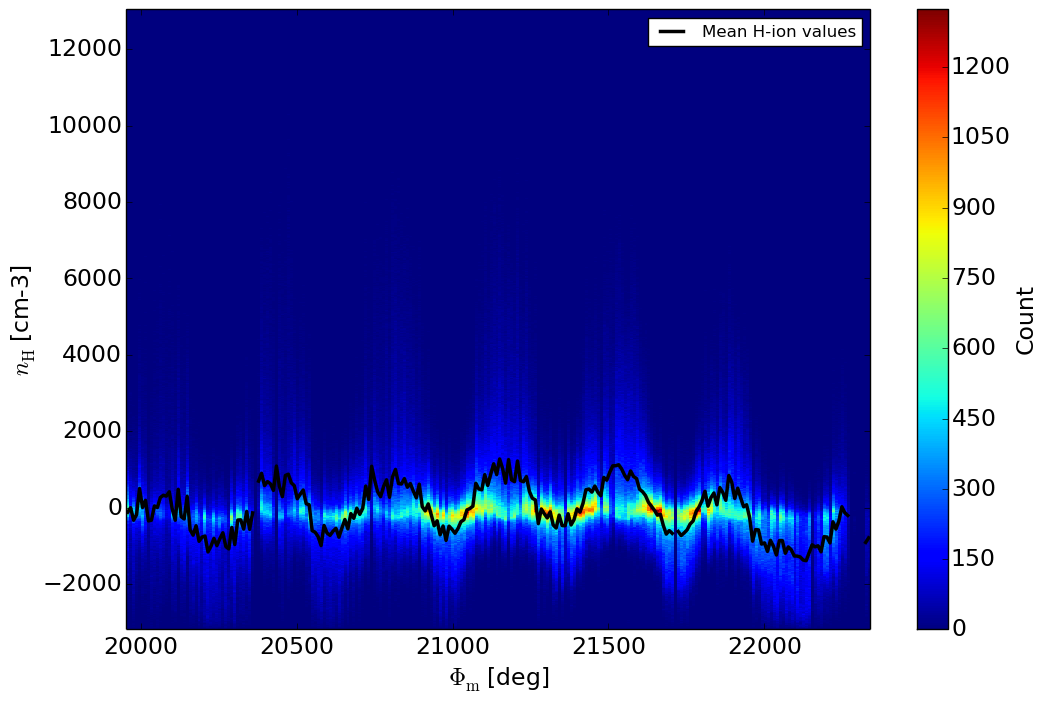

In [284]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['cnesjd'], day['h'] - h_corr, bins=[cnesjd_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

plt.plot(cnesjd_bins[:-1] + cnesjd_half_bin, cnesjd_mean, 'k-', linewidth=2.5, label='Mean H-ion values')
plt.legend();

In [285]:
h_corr += np.interp(day['cnesjd'], cnesjd_bins[not_nan] + cnesjd_half_bin, cnesjd_mean[not_nan])

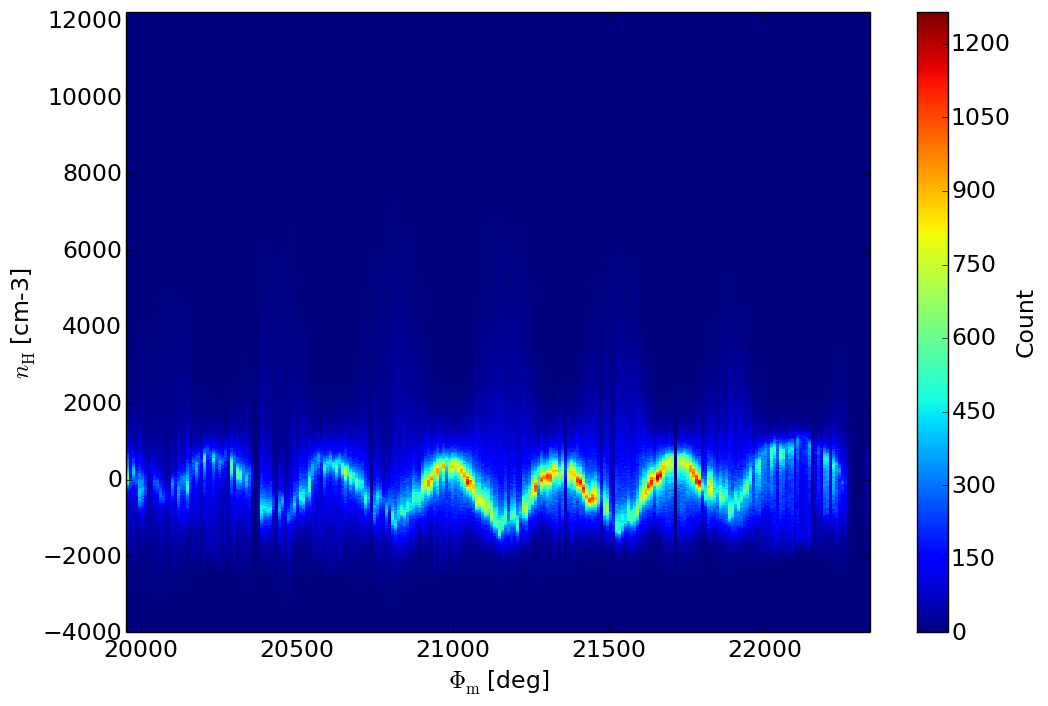

In [286]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['cnesjd'], day['h'] - h_corr, bins=[cnesjd_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

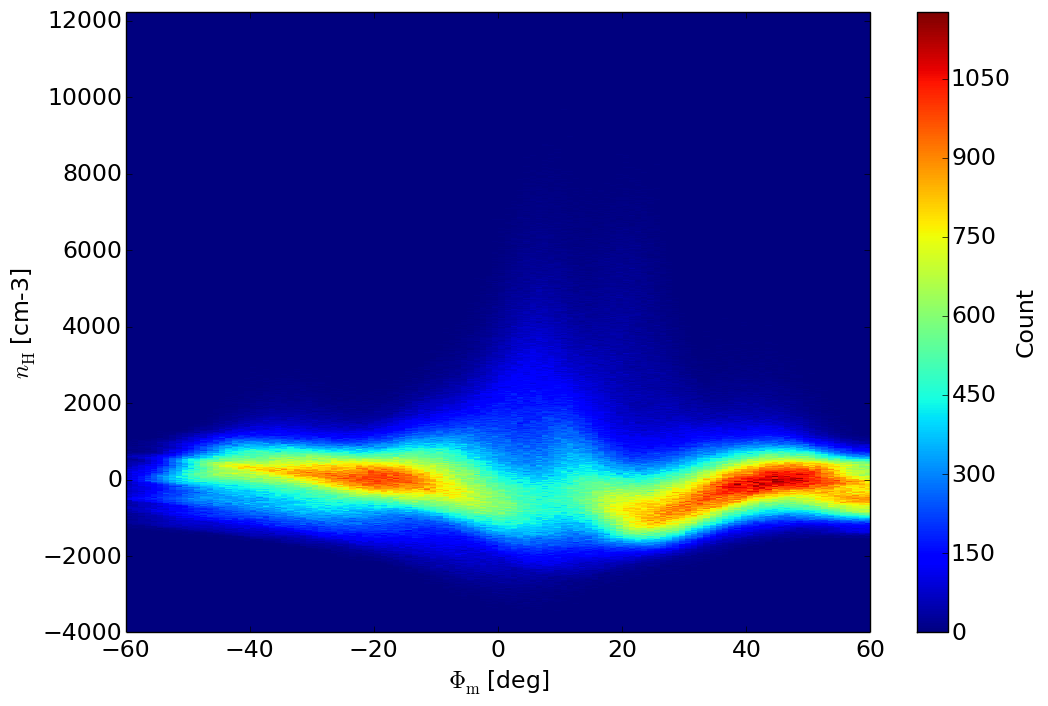

In [287]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['mlat'], day['h'] - h_corr, bins=[mlat_binnum, h_binnum])

cbar = plt.colorbar()
cbar.set_label('Count', size=17)
cbar.ax.tick_params(labelsize=17)

In [289]:
h_median, mlon_edge, mlat_edge, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'],
                                                              statistic='median', bins=[90, 30])

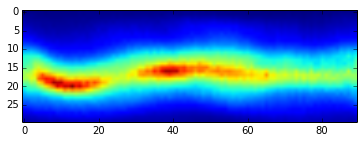

In [290]:
plt.imshow(h_median.T, interpolation=None);

In [291]:
h_median_corr, _, _, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'] - h_corr,
                                                              statistic='median', bins=[90, 30])

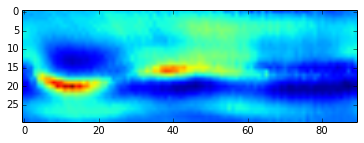

In [292]:
plt.imshow(h_median_corr.T, interpolation=None);